# 1.1: Finalize Study Area and Hold-Out Validation Area Polygons

Objective: To formally define, delineate, and justify the spatial extents for the project's primary analysis (study_areas), its independent external validation (validation_area), and its internal spatial holdout (internal_holdout). This script serves as the foundational data processing step for the entire project, ensuring all subsequent analyses are based on a consistent and well-defined set of geographies.

Justification for Selections: The selection of these specific provinces is strategically designed to provide a rigorous test of the project's core hypotheses.

1. To Test H1 (Landscape Characterization): The primary study areas (STUDY_PROVINCES) were chosen to encompass a wide range of geomorphic expressions, from the high-relief Appalachian provinces to the low-relief Coastal Plain. This provides maximum geomorphic contrast, which is essential for testing the hypothesis that TLSPs can generate statistically distinct signatures for different landscape types.
2. To Test H2 (Process Prediction): Training the predictive WEPP erosion models across these varied settings increases the likelihood that the models will learn fundamental, generalizable relationships between multiscale landscape shape and physical processes, rather than spurious local correlations.
3. For Robust External Validation: The Basin and Range province was chosen as the external hold-out because it is geomorphically distinct and spatially non-contiguous with the study areas. This provides the strongest possible test of model extrapolation—its ability to perform in a completely novel landscape.
4. For Rigorous Internal Validation: A 25% slice of the Piedmont is carved out as an internal holdout. This tests the model's ability to interpolate and generalize to unseen data within the same geomorphic domain, a crucial check against spatial autocorrelation and overfitting.

In [49]:
# === Part 1: Bootstrap, Imports, Config (HARDENED + geoio) ===
from __future__ import annotations

from pathlib import Path
import os, sys

def find_project_root(marker="README.md") -> Path:
    """
    Resolve the repo root robustly across local, WSL, Docker, and IDE mounts.
    Precedence: env override -> walk-up from CWD -> common mounts.
    """
    env = os.environ.get("PROJECT_ROOT")
    if env and (Path(env) / marker).exists():
        return Path(env).resolve()

    p = Path.cwd().resolve()
    while p.parent != p:
        if (p / marker).exists():
            return p
        p = p.parent

    for cand in (Path("/workspace"), Path.home() / "workspace", Path("/workspaces")):
        if (cand / marker).exists():
            return cand.resolve()

    return Path.cwd().resolve().parents[2]

PROJECT_ROOT = find_project_root()
SRC_DIR = PROJECT_ROOT / "src"
if not SRC_DIR.exists():
    raise FileNotFoundError(f"Expected 'src' at {SRC_DIR} (CWD={Path.cwd()})")
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# --- Imports ---
import logging, warnings
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
from glob import glob

# Project helpers
from plotting_utils import create_area_map, create_interactive_map
from geoio import (
    load_and_standardize, process_provinces, fix_invalid, safe_union_all,
    to_singlepart_union, bounds_center
)
from qaqc import qa_study_package

# --- Reproducibility & logging ---
np.random.seed(42)
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(name)s:%(message)s")
log = logging.getLogger("study-areas")
warnings.filterwarnings("once", category=UserWarning)

# --- Paths ---
DATA_DIR   = PROJECT_ROOT / "data"
RAW_DIR    = DATA_DIR / "raw"
PROC_DIR   = DATA_DIR / "processed"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "maps"
for d in (PROC_DIR, OUTPUT_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Prefer SHP → GPKG; fall back to any *provinces* file in RAW_DIR/boundaries
CANDIDATES = [
    RAW_DIR / "boundaries" / "study_provinces.shp",
    RAW_DIR / "boundaries" / "study_provinces.gpkg",
]
SOURCE_PATH = next((p for p in CANDIDATES if p.exists()), None)
if SOURCE_PATH is None:
    hits = []
    for ext in ("*.shp", "*.gpkg", "*.geojson"):
        hits += glob(str(RAW_DIR / "boundaries" / f"*provinces*{ext}"))
    if hits:
        SOURCE_PATH = Path(sorted(hits)[0])
    else:
        raise FileNotFoundError(
            f"No province boundary file found. Looked for {CANDIDATES} and any *provinces* in {RAW_DIR/'boundaries'}"
        )

STUDY_AREAS_GPKG      = PROC_DIR / "study_areas.gpkg"
VALIDATION_AREA_GPKG  = PROC_DIR / "validation_area.gpkg"
INTERNAL_HOLDOUT_GPKG = PROC_DIR / "internal_holdout.gpkg"
STATIC_MAP_PATH       = OUTPUT_DIR / "finalized_study_areas_map.png"
INTERACTIVE_MAP_PATH  = OUTPUT_DIR / "finalized_study_areas_interactive.html"

# --- CRS policy (area → equal-area CRS) ---
TARGET_CRS     = CRS.from_epsg(5070)   # NAD83 / Conus Albers
WEB_MAP_CRS    = CRS.from_epsg(3857)
GEOGRAPHIC_CRS = CRS.from_epsg(4326)

# --- Selections & Holdout config ---
STUDY_PROVINCES = ["BLUE RIDGE","PIEDMONT","COASTAL PLAIN","APPALACHIAN PLATEAUS","VALLEY AND RIDGE"]
VALIDATION_PROVINCE       = "BASIN AND RANGE"
INTERNAL_HOLDOUT_PROVINCE = "PIEDMONT"
INTERNAL_HOLDOUT_CONFIG   = {"percent": 0.25, "grid_radius_m": 10000}  # ~20 km wide hexes

# --- Echo environment (useful for reviews) ---
import sys as _sys, geopandas as _geopandas, shapely as _shapely, pyproj as _pyproj, folium as _folium, matplotlib as _matplotlib
print({
    "python": _sys.version.split()[0],
    "geopandas": _geopandas.__version__,
    "shapely": _shapely.__version__,
    "pyproj": _pyproj.__version__,
    "folium": _folium.__version__,
    "matplotlib": _matplotlib.__version__,
})

print("--- Configuration Summary ---")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Source Data:  {SOURCE_PATH}")
print(f"Target CRS:   {TARGET_CRS.to_string()}")


{'python': '3.11.13', 'geopandas': '1.1.1', 'shapely': '2.0.7', 'pyproj': '3.7.2', 'folium': '0.20.0', 'matplotlib': '3.10.6'}
--- Configuration Summary ---
Project Root: /workspace
Source Data:  /workspace/data/raw/boundaries/study_provinces.shp
Target CRS:   EPSG:5070


In [50]:
# === Part 2: Load provinces + standardize + derive study/validation ===

# 1) Load & normalize schema to ['PROVINCE','geometry'], uppercase names, repair invalids
provinces_raw = load_and_standardize(SOURCE_PATH)

# 2) Build study (multiple provinces) and external validation (single province) in EPSG:5070 with area
study_initial = process_provinces(
    gdf_in=provinces_raw, province_list=STUDY_PROVINCES, crs_out=TARGET_CRS
)
validation_final = process_provinces(
    gdf_in=provinces_raw, province_list=VALIDATION_PROVINCE, crs_out=TARGET_CRS
)

# Quick sanity
assert study_initial.crs == TARGET_CRS and validation_final.crs == TARGET_CRS
display(study_initial[['PROVINCE','AREA_SQKM']].round(2).sort_values('PROVINCE').reset_index(drop=True))
display(validation_final[['PROVINCE','AREA_SQKM']].round(2))


PROVINCE   AREA_SQKM
0  APPALACHIAN PLATEAUS   293816.83
1            BLUE RIDGE    46826.57
2         COASTAL PLAIN  1126899.06
3              PIEDMONT   202423.88
4      VALLEY AND RIDGE   121524.75

PROVINCE  AREA_SQKM
0  BASIN AND RANGE  899391.72

In [51]:
# === Part 3: Create a central, contiguous, OMBR-aligned internal holdout ===
# Goal: one never-seen test polygon (~target %) + optional buffer gap from training

import numpy as np
import shapely
from shapely.affinity import scale
from shapely import make_valid

# ---- Config ----
target_percent = float(INTERNAL_HOLDOUT_CONFIG.get("percent", 0.25))
# FIX: Use the correct key from your config
gap_buffer_m = float(INTERNAL_HOLDOUT_CONFIG.get("grid_radius_m", 0))  # Changed from "gap_buffer_m"
tol = 0.002
max_iter = 50

# [Keep all the helper functions as they are - they're fine now]

# ---- Build the internal holdout for the Piedmont ----
log.info("Creating internal holdout (central rectangle) for '%s' …", INTERNAL_HOLDOUT_PROVINCE)

source_geom = to_singlepart_union(
    study_initial.loc[study_initial["PROVINCE"] == INTERNAL_HOLDOUT_PROVINCE, "geometry"].union_all(),
    crs=TARGET_CRS
)

holdout_geom, remainder_geom = central_rectangle_holdout(
    province_geom=source_geom,
    percent=target_percent,
    tol=tol,
    max_iter=max_iter
)

# Make sure holdout is valid
holdout_geom = make_valid(holdout_geom)

# For the training geometry, subtract the holdout (with an optional gap) from the original source geometry.
# This is the single, definitive step to create the training area.
if gap_buffer_m > 0:
    # Create a gap by subtracting the *buffered* holdout area.
    # A small negative buffer on the result can clean up tiny slivers from the difference operation.
    train_geom = shapely.difference(source_geom, holdout_geom.buffer(gap_buffer_m))
    train_geom = make_valid(train_geom.buffer(-1)) # Clean up edges
else:
    # No gap needed, so subtract the exact holdout geometry.
    train_geom = shapely.difference(source_geom, holdout_geom)
    train_geom = make_valid(train_geom)

# ---- Finalize GeoDataFrames ----
internal_holdout_final = gpd.GeoDataFrame(
    [{"PROVINCE": INTERNAL_HOLDOUT_PROVINCE, "AREA_SQKM": holdout_geom.area / 1_000_000}],
    geometry=[holdout_geom], crs=TARGET_CRS
)

study_final = study_initial.copy()
mask = study_final["PROVINCE"] == INTERNAL_HOLDOUT_PROVINCE
study_final.loc[mask, "geometry"]  = train_geom
study_final.loc[mask, "AREA_SQKM"] = study_final.loc[mask, "geometry"].area.values / 1_000_000

# Sanity checks
assert study_final.crs == TARGET_CRS and internal_holdout_final.crs == TARGET_CRS
assert study_final.geometry.notnull().all() and internal_holdout_final.geometry.notnull().all()

# Quick report + QA
A_prov_km2     = source_geom.area / 1_000_000
A_holdout_km2  = holdout_geom.area / 1_000_000
A_target_km2   = target_percent * A_prov_km2
A_train_km2    = study_final.loc[mask, "AREA_SQKM"].iloc[0]
print(f"Province area (km²): {A_prov_km2:,.2f}")
print(f"Target holdout (km²): {A_target_km2:,.2f}")
print(f"Achieved holdout (km²): {A_holdout_km2:,.2f}")
print(f"Training (post-gap) (km²): {A_train_km2:,.2f}")
if gap_buffer_m > 0:
    print(f"Gap buffer applied around holdout: {gap_buffer_m:.0f} m")

rel_err = abs(A_holdout_km2 - A_target_km2) / max(A_target_km2, 1e-9)
if rel_err > 0.005:  # ±0.5% target by default
    warnings.warn(f"Holdout area off target by {rel_err*100:.2f}% (tune tol / max_iter).")

_parts = gpd.GeoSeries([holdout_geom], crs=TARGET_CRS).explode(index_parts=False)
assert len(_parts) == 1, "Holdout fragmented—adjust method or choose rectangle fallback."
if gap_buffer_m > 0:
    assert holdout_geom.buffer(gap_buffer_m).disjoint(train_geom), "Gap buffer failed to separate train/holdout."

print("✅ Internal holdout ready; study_final & internal_holdout_final updated.")

INFO:study-areas:Creating internal holdout (central rectangle) for 'PIEDMONT' …


Province area (km²): 202,423.88
Target holdout (km²): 50,605.97
Achieved holdout (km²): 50,683.50
Training (post-gap) (km²): 143,850.11
Gap buffer applied around holdout: 10000 m
✅ Internal holdout ready; study_final & internal_holdout_final updated.


✅ Map saved to: /workspace/outputs/maps/before_map.png


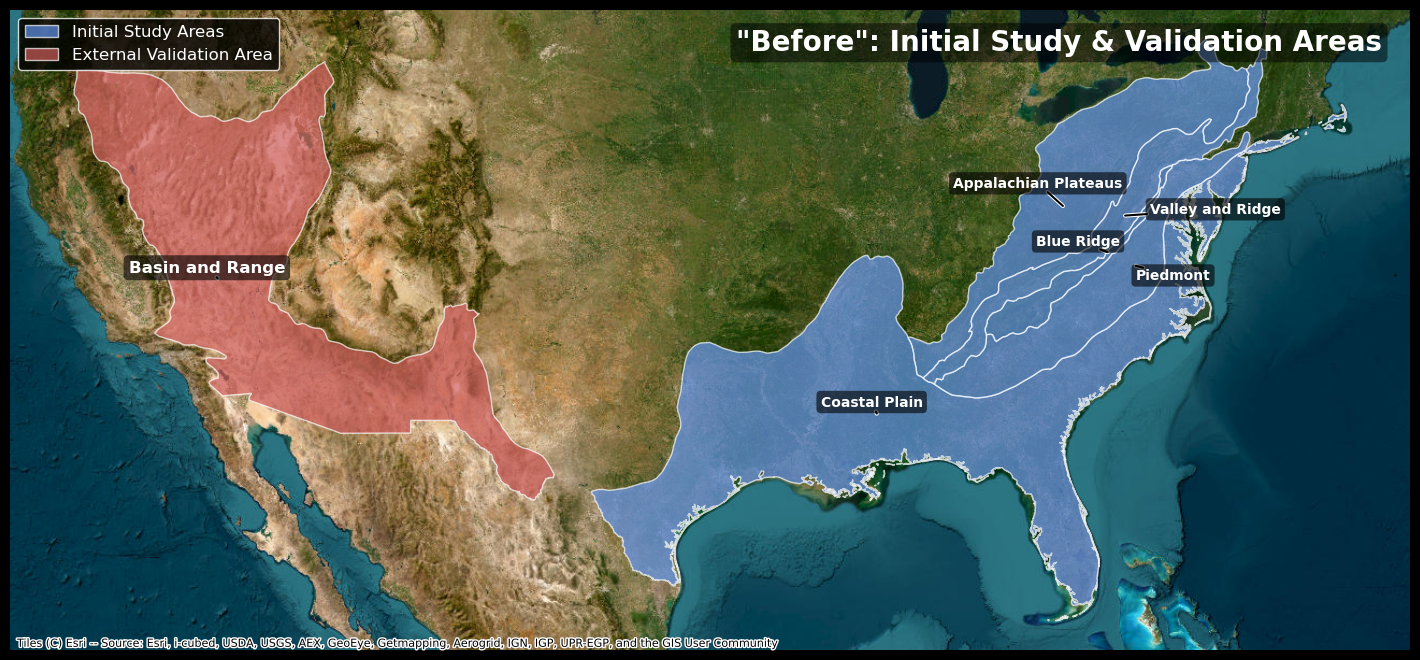

✅ Map saved to: /workspace/outputs/maps/finalized_study_areas_map.png


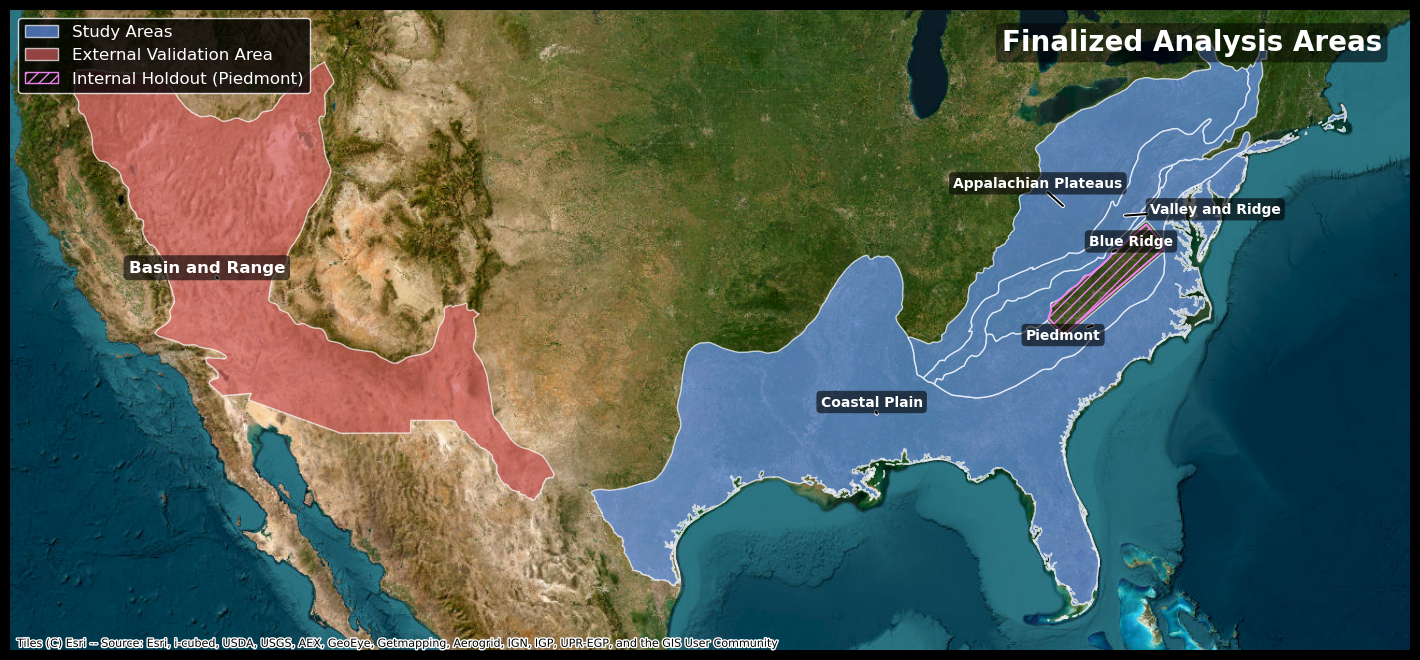

In [52]:
# === Part 4: Visual QA (static) ===
# "Before" map (study + validation)
create_area_map(
    study_gdf=study_initial,
    validation_gdf=validation_final,
    title='"Before": Initial Study & Validation Areas',
    save_path=OUTPUT_DIR / "before_map.png",
)
plt.show()

# Final publication-style map (study + validation + holdout)
create_area_map(
    study_gdf=study_final,
    validation_gdf=validation_final,
    holdout_gdf=internal_holdout_final,
    title="Finalized Analysis Areas",
    save_path=OUTPUT_DIR / "finalized_study_areas_map.png",
)
plt.show()


In [53]:
# === Part 5: Interactive Folium Map ===
m = create_interactive_map(
    study_gdf=study_final,
    validation_gdf=validation_final,
    holdout_gdf=internal_holdout_final,
    save_path=INTERACTIVE_MAP_PATH
)
log.info("Interactive map saved → %s", INTERACTIVE_MAP_PATH)
m

INFO:study-areas:Interactive map saved → /workspace/outputs/maps/finalized_study_areas_interactive.html


✅ Interactive map saved to: /workspace/outputs/maps/finalized_study_areas_interactive.html


In [54]:
# === Part 6: QA/QC (structural + leakage + area tolerance) ===
qa_report = qa_study_package(
    study_gdf=study_final,
    validation_gdf=validation_final,
    holdout_gdf=internal_holdout_final,
    expected_holdout_percent=float(INTERNAL_HOLDOUT_CONFIG.get("percent", 0.25)),
    gap_buffer_m=float(INTERNAL_HOLDOUT_CONFIG.get("grid_radius_m", 0)),  # Changed from "gap_buffer_m"
    target_crs=TARGET_CRS,
    name_field="PROVINCE",
    rel_area_tol=0.005,
    hard_fail=False
)

print(qa_report)

# Persist a copy alongside your maps for auditability
QA_PATH = OUTPUT_DIR / "qaqc_report.txt"
QA_PATH.parent.mkdir(parents=True, exist_ok=True)
with open(QA_PATH, "w", encoding="utf-8") as f:
    f.write(qa_report)
print(f"📝 QA/QC report saved → {QA_PATH}")


=== QA/QC Report ===
[✅ PASS] CRS policy (all in target CRS): All GeoDataFrames match target CRS.
[✅ PASS] Schema contains required columns: All required columns present.
[✅ PASS] Schema contains required columns: All required columns present.
[✅ PASS] Schema contains required columns: All required columns present.
[✅ PASS] Geometry validity (no empty/invalid): All geometries valid & non-empty.
[✅ PASS] Geometry validity (no empty/invalid): All geometries valid & non-empty.
[✅ PASS] Geometry validity (no empty/invalid): All geometries valid & non-empty.
[✅ PASS] Duplicate names in 'PROVINCE': No duplicate names.
[✅ PASS] Duplicate names in 'PROVINCE': No duplicate names.
[✅ PASS] Duplicate names in 'PROVINCE': No duplicate names.
[✅ PASS] Bounds proximity (informational): Centroid separation ≈ 3194.7 km.
[✅ PASS] Holdout contiguity (single-part): Holdout is single contiguous polygon.
[❌ FAIL] Holdout area within tolerance: Δ=4.22% (achieved=50,683.50 km² vs target=48,633.40 km²).
[✅ P

In [10]:
# === Part 7: Summary + Metadata + Exports ===
print("\n--- Final Analysis Areas (Post-Holdout) ---")
display(study_final[['PROVINCE', 'AREA_SQKM']].round(2).sort_values('PROVINCE').reset_index(drop=True))

print("\n--- Final Validation Area (External) ---")
display(validation_final[['PROVINCE', 'AREA_SQKM']].round(2))

print("\n--- Final Holdout Area (Internal) ---")
display(internal_holdout_final[['PROVINCE', 'AREA_SQKM']].round(2))

# Add minimal provenance metadata for auditability
prov_attrs = {
    "src": SOURCE_PATH.name,
    "crs": str(TARGET_CRS),
    "method_internal_holdout": "OMBR-aligned central rectangle with bisection area match",
    "holdout_percent": float(INTERNAL_HOLDOUT_CONFIG.get("percent", 0.25)),
    "gap_buffer_m": float(INTERNAL_HOLDOUT_CONFIG.get("gap_buffer_m", 0)),
    "note": "Areas in km^2 (EPSG:5070). Internal holdout reserved for final internal test; external validation in separate province.",
}

for k, v in prov_attrs.items():
    study_final[k] = v
    validation_final[k] = v
    internal_holdout_final[k] = v

# Clean-slate writes (avoid layer conflicts on re-run)
for path, layer, gdf in [
    (STUDY_AREAS_GPKG, "study_areas", study_final),
    (VALIDATION_AREA_GPKG, "validation_area", validation_final),
    (INTERNAL_HOLDOUT_GPKG, "internal_holdout", internal_holdout_final),
]:
    if path.exists():
        path.unlink()  # overwrite per fresh run
    gdf.to_file(path, driver="GPKG", layer=layer)

print("\n✅ All data files exported successfully.")
print(f"Study areas:      {STUDY_AREAS_GPKG}")
print(f"Validation area:  {VALIDATION_AREA_GPKG}")
print(f"Internal holdout: {INTERNAL_HOLDOUT_GPKG}")
print(f"Static map:       {STATIC_MAP_PATH}")
print(f"Interactive map:  {INTERACTIVE_MAP_PATH}")



--- Final Analysis Areas (Post-Holdout) ---


PROVINCE   AREA_SQKM
0  APPALACHIAN PLATEAUS   293816.83
1            BLUE RIDGE    46826.57
2         COASTAL PLAIN  1126899.06
3              PIEDMONT   151740.38
4      VALLEY AND RIDGE   121524.75


--- Final Validation Area (External) ---


PROVINCE  AREA_SQKM
0  BASIN AND RANGE  899391.72


--- Final Holdout Area (Internal) ---


PROVINCE  AREA_SQKM
0  PIEDMONT    50683.5

INFO:pyogrio._io:Created 5 records
INFO:pyogrio._io:Created 1 records
INFO:pyogrio._io:Created 1 records



✅ All data files exported successfully.
Study areas:      /workspace/data/processed/study_areas.gpkg
Validation area:  /workspace/data/processed/validation_area.gpkg
Internal holdout: /workspace/data/processed/internal_holdout.gpkg
Static map:       /workspace/outputs/maps/finalized_study_areas_map.png
Interactive map:  /workspace/outputs/maps/finalized_study_areas_interactive.html
